In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix  # for evaluating results

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

## Convert MNIST to Torch Tensors

In [2]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

Available devices  1
Current cuda device  0


In [4]:
# transform = transforms.ToTensor()  
# # There are many other transforms, for this one, we only use ToTensor

train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

## Data Loader

We're going to take advantage of a built-in torchvision dataset tool called <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder'><tt><strong>ImageFolder</strong></tt></a>.

In [5]:
root = '../PYTORCH_NOTEBOOKS/Data/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'),
                                  transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'),
                                 transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10,
                          shuffle=True, pin_memory=False)
test_loader = DataLoader(test_data, batch_size=10,
                         shuffle=True, pin_memory=False)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 18743
Testing images available:  6251


Label: [  1   0   1   0   0   1   0   1   0   0]
Class:  DOG CAT DOG CAT CAT DOG CAT DOG CAT CAT


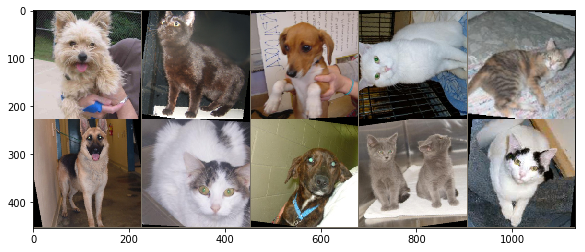

In [6]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:3}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));
#plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the Model

In [7]:
# Using CNN
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1)
        self.conv1 = nn.Conv2d(3, 6, 3, 1) 
        # Above: 6 filters -> pooling
        # Size after conv2d = (224 - 3 + 1) = 222x222
        # Size after max pool = 111x111
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # Above: 16 filters -> pooling
        # Size after conv2d = (111 - 3 + 1) = 109x109
        # Size after max pool = 54x54
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        
        # below is essentially flattening and taking batch size into account
        X = X.view(-1, 54*54*16)  # -1 so that we can vary the batch size
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [8]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [9]:
if use_cuda:
    model = model.cuda()

next(model.parameters()).is_cuda # Need to send model to GPU as well.

True

In [10]:
# Count Parameters (Optional)

In [11]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [12]:
count_parameters(model)

   162
     6
   864
    16
5598720
   120
 10080
    84
   168
     2
______
5610222


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model

In [14]:
import time
start_time = time.time()

epochs = 3

# max_trn_batch = None
# max_tst_batch = None
max_trn_batch = 800
max_tst_batch = 300

print_every = 200 # Prints every X number of mini-batched

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        if use_cuda:
            X_train, y_train = X_train.cuda(), y_train.cuda()
            
        # Limit the number of batches
        if (max_trn_batch is not None) & (b == max_trn_batch):
            break
        b+=1
        
        # Apply the model
        # y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        y_pred = model(X_train)  
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%print_every == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{train_loader.batch_size*b:6}/{len(train_data)})]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(train_loader.batch_size*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            if use_cuda:
                X_test, y_test = X_test.cuda(), y_test.cuda()
            
            if (max_tst_batch is not None) & (b == max_tst_batch):
                break
            
            # Apply the model
            y_val = model(X_test) 

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [  2000/18743)]  loss: 0.72995484  accuracy:  57.800%
epoch:  0  batch:  400 [  4000/18743)]  loss: 0.72048914  accuracy:  59.725%
epoch:  0  batch:  600 [  6000/18743)]  loss: 0.51717865  accuracy:  61.183%
epoch:  0  batch:  800 [  8000/18743)]  loss: 0.47844023  accuracy:  62.975%
epoch:  1  batch:  200 [  2000/18743)]  loss: 0.59345317  accuracy:  68.600%
epoch:  1  batch:  400 [  4000/18743)]  loss: 0.80557024  accuracy:  69.700%
epoch:  1  batch:  600 [  6000/18743)]  loss: 0.70268536  accuracy:  70.017%
epoch:  1  batch:  800 [  8000/18743)]  loss: 0.45919830  accuracy:  70.850%
epoch:  2  batch:  200 [  2000/18743)]  loss: 0.67234093  accuracy:  74.850%
epoch:  2  batch:  400 [  4000/18743)]  loss: 0.49859625  accuracy:  73.900%
epoch:  2  batch:  600 [  6000/18743)]  loss: 0.54922557  accuracy:  73.833%
epoch:  2  batch:  800 [  8000/18743)]  loss: 0.49954957  accuracy:  74.263%

Duration: 315 seconds


In [15]:
# Save Model
torch.save(model.state_dict(), 'CustomImageCNNModel.pt')

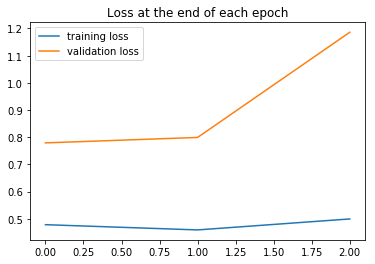

In [16]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

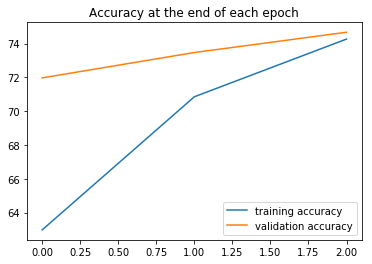

In [17]:
plt.plot([float(t)/(max_trn_batch*train_loader.batch_size)*100 for t in train_correct], label='training accuracy')
plt.plot([float(t)/(max_tst_batch*test_loader.batch_size)*100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [25]:
# Extract the data all at once, not in batches
# Reduced to prevent running out of memory
test_load_all = DataLoader(test_data, batch_size=10, shuffle=False)

In [26]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [40]:
# dump_tensors()

In [42]:
# torch.cuda.empty_cache()
# dump_tensors()

In [29]:
# del train_loader, test_loader, 
# del y_train, y_test

In [30]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        if use_cuda:
            X_test, y_test = X_test.cuda(), y_test.cuda()
        
        #y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        y_val = model(X_test)  
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 4695/6251 =  75.108%


In [39]:
# import seaborn as sns
# arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
# df_cm = pd.DataFrame(arr, class_names, class_names)
# plt.figure(figsize = (9,6))
# sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
# plt.xlabel("prediction")
# plt.ylabel("label (ground truth)")
# plt.show();

## Download a pretrained model
Torchvision has a number of proven models available through <a href='https://pytorch.org/docs/stable/torchvision/models.html#classification'><tt><strong>torchvision.models</strong></tt></a>:
<ul>
<li><a href="https://arxiv.org/abs/1404.5997">AlexNet</a></li>
<li><a href="https://arxiv.org/abs/1409.1556">VGG</a></li>
<li><a href="https://arxiv.org/abs/1512.03385">ResNet</a></li>
<li><a href="https://arxiv.org/abs/1602.07360">SqueezeNet</a></li>
<li><a href="https://arxiv.org/abs/1608.06993">DenseNet</a></li>
<li><a href="https://arxiv.org/abs/1512.00567">Inception</a></li>
<li><a href="https://arxiv.org/abs/1409.4842">GoogLeNet</a></li>
<li><a href="https://arxiv.org/abs/1807.11164">ShuffleNet</a></li>
<li><a href="https://arxiv.org/abs/1801.04381">MobileNet</a></li>
<li><a href="https://arxiv.org/abs/1611.05431">ResNeXt</a></li>
</ul>
These have all been trained on the <a href='http://www.image-net.org/'>ImageNet</a> database of images. Our only task is to reduce the output of the fully connected layers from (typically) 1000 categories to just 2.

To access the models, you can construct a model with random weights by calling its constructor:<br>
<pre>resnet18 = models.resnet18()</pre>
You can also obtain a pre-trained model by passing pretrained=True:<br>
<pre>resnet18 = models.resnet18(pretrained=True)</pre>
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Feel free to investigate the different models available. Each one will be downloaded to a cache directory the first time they're accessed - from then on they'll be available locally.

For its simplicity and effectiveness, we'll use AlexNet:

In [44]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Nikhil/.cache\torch\checkpoints\alexnet-owt-4df8aa71.pth
93.2%

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

## Freeze feature parameters
We want to freeze the pre-trained weights & biases. We set <tt>.requires_grad</tt> to False so we don't backprop through them.

In [45]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

## Modify the classifier
Next we need to modify the fully connected layers to produce a binary output. The section is labeled "classifier" in the AlexNet model.<br>
Note that when we assign new layers, their parameters default to <tt>.requires_grad=True</tt>.

In [46]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_featur

In [51]:
if use_cuda:
    AlexNetmodel = AlexNetmodel.cuda()

next(AlexNetmodel.parameters()).is_cuda # Need to send model to GPU as well.

True

In [47]:
# These are the TRAINABLE parameters:
count_parameters(AlexNetmodel)

9437184
  1024
  2048
     2
______
9440258


## Define loss function & optimizer
We only want to optimize the classifier parameters, as the feature parameters are frozen.

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

## Train the model
Remember, we're only training the fully connected layers. The convolutional layers have fixed weights and biases. For this reason, we only need to run one epoch.

In [52]:
import time
start_time = time.time()

epochs = 1

# max_trn_batch = None
# max_tst_batch = None
max_trn_batch = 800
max_tst_batch = 300

print_every = 200 # Prints every X number of mini-batched

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        if use_cuda:
            X_train, y_train = X_train.cuda(), y_train.cuda()
            
        # Limit the number of batches
        if (max_trn_batch is not None) & (b == max_trn_batch):
            break
        b+=1
        
        # Apply the model
        # y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        y_pred = AlexNetmodel(X_train)  
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%print_every == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{train_loader.batch_size*b:6}/{len(train_data)})]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(train_loader.batch_size*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            if use_cuda:
                X_test, y_test = X_test.cuda(), y_test.cuda()
            
            if (max_tst_batch is not None) & (b == max_tst_batch):
                break
            
            # Apply the model
            y_val = AlexNetmodel(X_test) 

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [  2000/18743)]  loss: 0.02591582  accuracy:  89.250%
epoch:  0  batch:  400 [  4000/18743)]  loss: 0.47997269  accuracy:  91.125%
epoch:  0  batch:  600 [  6000/18743)]  loss: 0.04118253  accuracy:  92.033%
epoch:  0  batch:  800 [  8000/18743)]  loss: 0.25889510  accuracy:  92.412%

Duration: 100 seconds


In [54]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/(test_loader.batch_size*max_tst_batch):.3f}%')

[tensor(2840, device='cuda:0')]
Test accuracy: 94.667%


## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.<br>
Pick a number from 0 to 6250, assign it to "x", and we'll use that value to select an image from the Cats and Dogs test set.

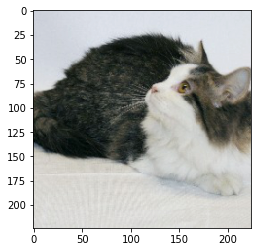

In [56]:
x = 2019
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [61]:
# CNN Model Prediction:

model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].cuda().view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT


In [62]:
# AlexNet Model Prediction:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].cuda().view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT
